In [1]:
# ================================================================
# EXPERIMENT 4: NUMBER OF EXPERTS SWEEP
# Testing: 2, 3, 4, 8 experts
# ================================================================


# HYPOTHESIS:
# - Too few experts (2): Limited capacity, but stable
# - Sweet spot (3-4): Good balance of capacity and trainability
# - Too many (8): High capacity but collapse-prone, harder to train

In [2]:
# ================================================================
# IMPORTS AND SETUP
# ================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
from collections import defaultdict

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (18, 12)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

print("="*60)
print("EXPERIMENT 4: NUMBER OF EXPERTS SWEEP")
print("="*60)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("="*60)

EXPERIMENT 4: NUMBER OF EXPERTS SWEEP
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


In [3]:
# ================================================================
# DATA LOADING
# ================================================================

def load_mnist(batch_size=64, data_dir='/kaggle/working/data'):
    """Load MNIST dataset."""
    print("\nLoading MNIST Dataset...")
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=2, pin_memory=True)
    
    print(f"Training samples: {len(train_dataset):,}")
    print(f"Test samples: {len(test_dataset):,}")
    
    return train_loader, test_loader

In [4]:
# ================================================================
# MODEL COMPONENTS
# ================================================================

class Expert(nn.Module):
    """Single expert network."""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.expert_id = None
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)


class GatingNetwork(nn.Module):
    """Gating network."""
    def __init__(self, input_dim, num_experts):
        super(GatingNetwork, self).__init__()
        self.fc = nn.Linear(input_dim, num_experts)
        self.num_experts = num_experts
        
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, x, top_k=1):
        logits = self.fc(x)
        all_gates = F.softmax(logits, dim=1)
        top_gates, top_indices = torch.topk(all_gates, top_k, dim=1)
        top_gates = top_gates / (top_gates.sum(dim=1, keepdim=True) + 1e-10)
        
        return top_indices, top_gates, all_gates


class MoE(nn.Module):
    """MoE with configurable number of experts."""
    def __init__(self, input_dim, num_experts, expert_hidden=64, 
                 output_dim=10, top_k=1):
        super(MoE, self).__init__()
        
        self.num_experts = num_experts
        self.top_k = top_k
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Gating
        self.gating = GatingNetwork(input_dim, num_experts)
        
        # Experts
        self.experts = nn.ModuleList([
            Expert(input_dim, expert_hidden, output_dim)
            for i in range(num_experts)
        ])
        
        for i, expert in enumerate(self.experts):
            expert.expert_id = i
        
        # Tracking
        self.expert_counts = torch.zeros(num_experts)
        
    def forward(self, x):
        """Forward pass with load balancing."""
        batch_size = x.size(0)
        
        if x.dim() > 2:
            x = x.view(batch_size, -1)
        
        # Gating decisions
        top_indices, top_gates, all_gates = self.gating(x, self.top_k)
        
        # Initialize output
        output = torch.zeros(batch_size, self.output_dim).to(x.device)
        
        # Route to experts
        for k in range(self.top_k):
            expert_idx = top_indices[:, k]
            gate_weight = top_gates[:, k]
            
            for expert_id in range(self.num_experts):
                mask = (expert_idx == expert_id)
                
                if mask.any():
                    expert_input = x[mask]
                    expert_output = self.experts[expert_id](expert_input)
                    output[mask] += gate_weight[mask].unsqueeze(1) * expert_output
                    self.expert_counts[expert_id] += mask.sum().item()
        
        # Load balancing loss
        aux_loss = self.compute_load_balancing_loss(all_gates, top_indices)
        
        return output, aux_loss
    
    def compute_load_balancing_loss(self, gates, top_indices):
        """Switch Transformer load balancing loss."""
        importance = gates.mean(dim=0)
        load = torch.zeros(self.num_experts).to(gates.device)
        
        for i in range(self.num_experts):
            mask = (top_indices == i).any(dim=1)
            load[i] = mask.float().mean()
        
        loss = self.num_experts * (importance * load).sum()
        return loss
    
    def count_parameters(self):
        """Count trainable parameters."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def get_expert_utilization(self):
        """Get expert utilization statistics."""
        total = self.expert_counts.sum()
        if total == 0:
            percentages = [0.0] * self.num_experts
            entropy = 0.0
        else:
            percentages = (self.expert_counts / total * 100).tolist()
            probs = self.expert_counts / total
            entropy = -(probs * torch.log(probs + 1e-10)).sum().item()
        
        return {
            'counts': self.expert_counts.tolist(),
            'percentages': percentages,
            'entropy': entropy,
            'max_usage': max(percentages) if percentages else 0,
            'min_usage': min(percentages) if percentages else 0,
            'std_usage': np.std(percentages) if percentages else 0
        }
    
    def reset_expert_counts(self):
        """Reset expert usage tracking."""
        self.expert_counts = torch.zeros(self.num_experts)

In [5]:
# ================================================================
# TRAINING FUNCTIONS
# ================================================================

def train_epoch(model, train_loader, optimizer, criterion, device, epoch, alpha=0.01):
    """Train for one epoch."""
    model.train()
    total_task_loss = 0
    total_aux_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output, aux_loss = model(data)
        
        task_loss = criterion(output, target)
        total_loss_batch = task_loss + alpha * aux_loss
        
        total_loss_batch.backward()
        optimizer.step()
        
        total_task_loss += task_loss.item()
        total_aux_loss += aux_loss.item()
        
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)
        
        pbar.set_postfix({
            'loss': f'{task_loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    avg_task_loss = total_task_loss / len(train_loader)
    avg_aux_loss = total_aux_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    return avg_task_loss, avg_aux_loss, train_acc


def evaluate(model, test_loader, criterion, device):
    """Evaluate model."""
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, _ = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    
    return test_loss, test_acc


def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, 
                alpha=0.01, device='cuda'):
    """Complete training loop."""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    model = model.to(device)
    
    history = {
        'train_loss': [],
        'aux_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'expert_utilization': [],
        'epoch_times': []
    }
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        model.reset_expert_counts()
        
        # Train
        task_loss, aux_loss, train_acc = train_epoch(
            model, train_loader, optimizer, criterion, device, epoch, alpha
        )
        
        # Evaluate
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        
        # Get utilization
        util = model.get_expert_utilization()
        
        epoch_time = time.time() - start_time
        
        # Save history
        history['train_loss'].append(task_loss)
        history['aux_loss'].append(aux_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['expert_utilization'].append(util)
        history['epoch_times'].append(epoch_time)
        
        # Print summary
        print(f"\nEpoch {epoch}/{epochs}:")
        print(f"  Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        print(f"  Expert Usage: {[f'{p:.1f}%' for p in util['percentages']]}")
        print(f"  Entropy: {util['entropy']:.3f} | Std: {util['std_usage']:.2f}")
    
    return history

In [6]:
# ================================================================
# EXPERIMENT RUNNER
# ================================================================

def run_expert_count_experiment(train_loader, test_loader, device='cuda'):
    """
    Test different numbers of experts: 2, 3, 4, 8
    
    Questions to answer:
    1. Does more experts improve accuracy?
    2. Which configuration is most stable?
    3. When does collapse become harder to prevent?
    """
    print("\n" + "="*60)
    print("EXPERIMENT: NUMBER OF EXPERTS SWEEP")
    print("="*60)
    
    expert_counts = [2, 3, 4, 8]
    results = {}
    
    # Fixed hyperparameters
    ALPHA = 0.01  
    EXPERT_HIDDEN = 64
    EPOCHS = 10
    
    for num_experts in expert_counts:
        print(f"\n{'='*60}")
        print(f"Testing {num_experts} Experts")
        print(f"{'='*60}")
        
        # Create model
        model = MoE(
            input_dim=784,
            num_experts=num_experts,
            expert_hidden=EXPERT_HIDDEN,
            output_dim=10,
            top_k=1
        )
        
        print(f"Model parameters: {model.count_parameters():,}")
        
        # Train
        history = train_model(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            epochs=EPOCHS,
            lr=0.001,
            alpha=ALPHA,
            device=device
        )
        
        # Save results
        final_util = history['expert_utilization'][-1]
        results[num_experts] = {
            'history': history,
            'final_acc': history['test_acc'][-1],
            'best_acc': max(history['test_acc']),
            'final_util': final_util,
            'avg_time': np.mean(history['epoch_times']),
            'params': model.count_parameters()
        }
        
        # Print summary
        print(f"\nSummary for {num_experts} Experts:")
        print(f"   Final Accuracy: {results[num_experts]['final_acc']:.2f}%")
        print(f"   Best Accuracy:  {results[num_experts]['best_acc']:.2f}%")
        print(f"   Entropy:        {final_util['entropy']:.3f}")
        print(f"   Usage Std:      {final_util['std_usage']:.2f}")
        print(f"   Parameters:     {results[num_experts]['params']:,}")
        print(f"   Avg Epoch Time: {results[num_experts]['avg_time']:.1f}s")
    
    return results

In [7]:
# ================================================================
# VISUALIZATION
# ================================================================

def plot_expert_count_analysis(results, save_path='/kaggle/working/expert_count_analysis.png'):
    """Create comprehensive visualization of expert count experiment."""
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    expert_counts = sorted(results.keys())
    colors = ['red', 'blue', 'green', 'purple']
    
    # Row 1: Expert utilization for each configuration
    for idx, num_experts in enumerate(expert_counts):
        ax = fig.add_subplot(gs[0, idx])
        history = results[num_experts]['history']
        epochs = range(1, len(history['test_acc']) + 1)
        
        for expert_id in range(num_experts):
            percentages = [
                util['percentages'][expert_id]
                for util in history['expert_utilization']
            ]
            ax.plot(epochs, percentages, marker='o', label=f'Expert {expert_id}', linewidth=2)
        
        balanced_line = 100 / num_experts
        ax.axhline(y=balanced_line, color='black', linestyle='--', alpha=0.5, label='Balanced')
        
        ax.set_xlabel('Epoch', fontsize=10)
        ax.set_ylabel('Utilization (%)', fontsize=10)
        ax.set_title(f'{num_experts} Experts', fontsize=12, fontweight='bold')
        ax.legend(fontsize=8, ncol=2 if num_experts > 4 else 1)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 100])
    
    # Row 2: Comparative metrics
    # Accuracy comparison
    ax = fig.add_subplot(gs[1, 0])
    for idx, num_experts in enumerate(expert_counts):
        history = results[num_experts]['history']
        epochs = range(1, len(history['test_acc']) + 1)
        ax.plot(epochs, history['test_acc'], marker='o', label=f'{num_experts} experts',
                color=colors[idx], linewidth=2)
    ax.axhline(y=97.52, color='gray', linestyle='--', alpha=0.7, label='Baseline (97.52%)')
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Test Accuracy (%)', fontsize=11)
    ax.set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([95, 99])
    
    # Entropy comparison
    ax = fig.add_subplot(gs[1, 1])
    for idx, num_experts in enumerate(expert_counts):
        history = results[num_experts]['history']
        epochs = range(1, len(history['test_acc']) + 1)
        entropies = [util['entropy'] for util in history['expert_utilization']]
        ax.plot(epochs, entropies, marker='o', label=f'{num_experts} experts',
                color=colors[idx], linewidth=2)
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Entropy', fontsize=11)
    ax.set_title('Gating Entropy', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Training time comparison
    ax = fig.add_subplot(gs[1, 2])
    num_experts_list = list(expert_counts)
    avg_times = [results[n]['avg_time'] for n in num_experts_list]
    bars = ax.bar(range(len(num_experts_list)), avg_times, color=colors, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(num_experts_list)))
    ax.set_xticklabels([f'{n} experts' for n in num_experts_list])
    ax.set_ylabel('Avg Time (s)', fontsize=11)
    ax.set_title('Training Time Per Epoch', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}s', ha='center', va='bottom', fontsize=10)
    
    # Row 3: Summary metrics
    # Final accuracy vs parameters
    ax = fig.add_subplot(gs[2, 0])
    params = [results[n]['params'] / 1000 for n in num_experts_list]  # In thousands
    final_accs = [results[n]['final_acc'] for n in num_experts_list]
    scatter = ax.scatter(params, final_accs, s=200, c=colors, alpha=0.7, edgecolors='black', linewidths=2)
    for i, n in enumerate(num_experts_list):
        ax.annotate(f'{n} experts', (params[i], final_accs[i]), 
                   xytext=(5, 5), textcoords='offset points', fontsize=10)
    ax.set_xlabel('Parameters (thousands)', fontsize=11)
    ax.set_ylabel('Final Accuracy (%)', fontsize=11)
    ax.set_title('Accuracy vs Model Size', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([96, 98])
    
    # Utilization variance (stability)
    ax = fig.add_subplot(gs[2, 1])
    stds = [results[n]['final_util']['std_usage'] for n in num_experts_list]
    bars = ax.bar(range(len(num_experts_list)), stds, color=colors, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(num_experts_list)))
    ax.set_xticklabels([f'{n} experts' for n in num_experts_list])
    ax.set_ylabel('Std Dev of Usage (%)', fontsize=11)
    ax.set_title('Expert Balance (Lower = Better)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Final utilization heatmap
    ax = fig.add_subplot(gs[2, 2])
    utilization_matrix = []
    labels = []
    for n in num_experts_list:
        util_percentages = results[n]['final_util']['percentages']
        # Pad with zeros to make same length
        padded = util_percentages + [0] * (8 - len(util_percentages))
        utilization_matrix.append(padded[:8])
        labels.append(f'{n} experts')
    
    im = ax.imshow(utilization_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=50)
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_xticks(range(8))
    ax.set_xticklabels([f'E{i}' for i in range(8)])
    ax.set_title('Final Expert Utilization Heatmap', fontsize=12, fontweight='bold')
    
    # Add values to heatmap
    for i in range(len(labels)):
        for j in range(num_experts_list[i]):
            value = utilization_matrix[i][j]
            if value > 0:
                text = ax.text(j, i, f'{value:.0f}%',
                             ha="center", va="center", color="black", fontsize=9)
    
    plt.colorbar(im, ax=ax, label='Usage (%)')
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nAnalysis plot saved to: {save_path}")
    plt.show()


def print_expert_count_summary(results):
    """Print comprehensive summary table."""
    print("\n" + "="*80)
    print("EXPERT COUNT EXPERIMENT - SUMMARY")
    print("="*80)
    
    print(f"\n{'Experts':<10} {'Accuracy':<12} {'Best Acc':<12} {'Entropy':<10} {'Std Usage':<12} {'Params':<12} {'Time/Epoch':<12}")
    print("-" * 80)
    
    for num_experts in sorted(results.keys()):
        r = results[num_experts]
        print(f"{num_experts:<10} {r['final_acc']:<12.2f}% {r['best_acc']:<12.2f}% "
              f"{r['final_util']['entropy']:<10.3f} {r['final_util']['std_usage']:<12.2f} "
              f"{r['params']:<12,} {r['avg_time']:<12.1f}s")
    
    print("="*80)
    
    # Find best configuration
    best_acc = max(results.values(), key=lambda x: x['final_acc'])
    best_balance = min(results.values(), key=lambda x: x['final_util']['std_usage'])
    best_efficiency = min(results.values(), key=lambda x: x['params'])
    
    print("\nBest Configurations:")
    for num_experts, r in results.items():
        if r == best_acc:
            print(f"   Highest Accuracy: {num_experts} experts ({r['final_acc']:.2f}%)")
        if r == best_balance:
            print(f"   Best Balance:     {num_experts} experts (std={r['final_util']['std_usage']:.2f})")
        if r == best_efficiency:
            print(f"   Most Efficient:   {num_experts} experts ({r['params']:,} params)")
    
    print("\nKey Findings:")
    
    # Check if accuracy improves with more experts
    accs = [results[n]['final_acc'] for n in sorted(results.keys())]
    if accs[-1] > accs[0]:
        print("More experts generally improved accuracy")
    else:
        print("More experts did not improve accuracy")
    
    # Check stability
    stds = [results[n]['final_util']['std_usage'] for n in sorted(results.keys())]
    if stds[-1] > stds[0]:
        print("More experts led to less balanced utilization")
    else:
        print("More experts maintained balance")
    
    # Sweet spot
    best_count = max(results.keys(), key=lambda n: results[n]['final_acc'])
    print(f"   Sweet spot appears to be: {best_count} experts")
    
    print("\n" + "="*80)

In [8]:
# ================================================================
# MAIN EXECUTION
# ================================================================

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64

# Load data
train_loader, test_loader = load_mnist(batch_size=BATCH_SIZE)

# Run experiment
results = run_expert_count_experiment(train_loader, test_loader, device=DEVICE)


Loading MNIST Dataset...


100%|██████████| 9.91M/9.91M [00:00<00:00, 44.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.16MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


Training samples: 60,000
Test samples: 10,000

EXPERIMENT: NUMBER OF EXPERTS SWEEP

Testing 2 Experts
Model parameters: 103,350


Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 1/10:
  Train Acc: 91.04% | Test Acc: 94.67%
  Expert Usage: ['50.6%', '49.4%']
  Entropy: 0.693 | Std: 0.63


Epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2/10:
  Train Acc: 95.58% | Test Acc: 95.66%
  Expert Usage: ['50.3%', '49.7%']
  Entropy: 0.693 | Std: 0.35


Epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3/10:
  Train Acc: 96.74% | Test Acc: 96.59%
  Expert Usage: ['50.1%', '49.9%']
  Entropy: 0.693 | Std: 0.14


Epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4/10:
  Train Acc: 97.39% | Test Acc: 96.76%
  Expert Usage: ['49.4%', '50.6%']
  Entropy: 0.693 | Std: 0.60


Epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5/10:
  Train Acc: 97.75% | Test Acc: 97.09%
  Expert Usage: ['49.6%', '50.4%']
  Entropy: 0.693 | Std: 0.45


Epoch 6:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6/10:
  Train Acc: 98.05% | Test Acc: 96.34%
  Expert Usage: ['49.5%', '50.5%']
  Entropy: 0.693 | Std: 0.49


Epoch 7:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7/10:
  Train Acc: 98.19% | Test Acc: 96.96%
  Expert Usage: ['49.9%', '50.1%']
  Entropy: 0.693 | Std: 0.06


Epoch 8:   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7825e5362700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7825e5362700>  
  Traceback (most recent call last):
  ^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()^^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    if w.is_alive():^^
 ^ ^
    File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process'  
^^ ^ ^ ^ ^ ^  ^ ^ ^ ^^
 ^  File "/us


Epoch 8/10:
  Train Acc: 98.43% | Test Acc: 97.09%
  Expert Usage: ['49.6%', '50.4%']
  Entropy: 0.693 | Std: 0.43


Epoch 9:   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7825e5362700>
Traceback (most recent call last):
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7825e5362700>
    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

     if w.is_alive():  self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      
  ^^^ ^^ ^ ^ ^  ^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^^ ^^  
   File "/usr/lib/py


Epoch 9/10:
  Train Acc: 98.63% | Test Acc: 97.19%
  Expert Usage: ['50.3%', '49.7%']
  Entropy: 0.693 | Std: 0.28


Epoch 10:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10/10:
  Train Acc: 98.79% | Test Acc: 97.34%
  Expert Usage: ['50.6%', '49.4%']
  Entropy: 0.693 | Std: 0.59

Summary for 2 Experts:
   Final Accuracy: 97.34%
   Best Accuracy:  97.34%
   Entropy:        0.693
   Usage Std:      0.59
   Parameters:     103,350
   Avg Epoch Time: 11.8s

Testing 3 Experts
Model parameters: 155,025


Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 1/10:
  Train Acc: 90.28% | Test Acc: 94.06%
  Expert Usage: ['34.2%', '33.3%', '32.5%']
  Entropy: 1.098 | Std: 0.70


Epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2/10:
  Train Acc: 95.09% | Test Acc: 95.64%
  Expert Usage: ['32.8%', '32.9%', '34.3%']
  Entropy: 1.098 | Std: 0.69


Epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3/10:
  Train Acc: 96.31% | Test Acc: 95.88%
  Expert Usage: ['33.3%', '33.3%', '33.3%']
  Entropy: 1.099 | Std: 0.01


Epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4/10:
  Train Acc: 96.71% | Test Acc: 95.82%
  Expert Usage: ['34.3%', '31.4%', '34.4%']
  Entropy: 1.098 | Std: 1.39


Epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5/10:
  Train Acc: 97.19% | Test Acc: 96.21%
  Expert Usage: ['33.5%', '34.1%', '32.4%']
  Entropy: 1.098 | Std: 0.73


Epoch 6:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6/10:
  Train Acc: 97.58% | Test Acc: 96.36%
  Expert Usage: ['32.5%', '32.3%', '35.2%']
  Entropy: 1.098 | Std: 1.32


Epoch 7:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7/10:
  Train Acc: 97.76% | Test Acc: 96.86%
  Expert Usage: ['33.9%', '33.5%', '32.6%']
  Entropy: 1.098 | Std: 0.53


Epoch 8:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8/10:
  Train Acc: 97.93% | Test Acc: 96.35%
  Expert Usage: ['34.2%', '33.2%', '32.6%']
  Entropy: 1.098 | Std: 0.66


Epoch 9:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9/10:
  Train Acc: 98.05% | Test Acc: 96.84%
  Expert Usage: ['33.5%', '34.0%', '32.5%']
  Entropy: 1.098 | Std: 0.63


Epoch 10:   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7825e5362700>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7825e5362700>    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive():  
       ^ ^  ^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self.


Epoch 10/10:
  Train Acc: 98.40% | Test Acc: 96.50%
  Expert Usage: ['32.4%', '33.4%', '34.3%']
  Entropy: 1.098 | Std: 0.78

Summary for 3 Experts:
   Final Accuracy: 96.50%
   Best Accuracy:  96.86%
   Entropy:        1.098
   Usage Std:      0.78
   Parameters:     155,025
   Avg Epoch Time: 11.9s

Testing 4 Experts
Model parameters: 206,700


Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7825e5362700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7825e5362700>
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^^    ^^if w.is_alive():^^
^ ^ ^^^  


Epoch 1/10:
  Train Acc: 89.13% | Test Acc: 93.75%
  Expert Usage: ['27.3%', '24.4%', '24.6%', '23.7%']
  Entropy: 1.385 | Std: 1.39


Epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2/10:
  Train Acc: 94.26% | Test Acc: 94.62%
  Expert Usage: ['26.1%', '25.6%', '22.9%', '25.4%']
  Entropy: 1.385 | Std: 1.25


Epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3/10:
  Train Acc: 95.51% | Test Acc: 95.23%
  Expert Usage: ['25.3%', '24.7%', '26.0%', '24.0%']
  Entropy: 1.386 | Std: 0.70


Epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4/10:
  Train Acc: 96.20% | Test Acc: 95.93%
  Expert Usage: ['24.6%', '24.8%', '25.3%', '25.3%']
  Entropy: 1.386 | Std: 0.30


Epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5/10:
  Train Acc: 96.71% | Test Acc: 95.74%
  Expert Usage: ['23.5%', '24.4%', '26.3%', '25.9%']
  Entropy: 1.385 | Std: 1.15


Epoch 6:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6/10:
  Train Acc: 96.91% | Test Acc: 95.70%
  Expert Usage: ['25.7%', '23.8%', '25.2%', '25.3%']
  Entropy: 1.386 | Std: 0.72


Epoch 7:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7/10:
  Train Acc: 97.26% | Test Acc: 96.31%
  Expert Usage: ['26.3%', '23.8%', '25.6%', '24.3%']
  Entropy: 1.385 | Std: 1.01


Epoch 8:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8/10:
  Train Acc: 97.48% | Test Acc: 96.19%
  Expert Usage: ['24.7%', '24.0%', '25.4%', '25.9%']
  Entropy: 1.386 | Std: 0.71


Epoch 9:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9/10:
  Train Acc: 97.46% | Test Acc: 96.36%
  Expert Usage: ['25.7%', '24.8%', '23.9%', '25.6%']
  Entropy: 1.386 | Std: 0.73


Epoch 10:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10/10:
  Train Acc: 97.78% | Test Acc: 96.09%
  Expert Usage: ['26.1%', '24.1%', '24.0%', '25.7%']
  Entropy: 1.386 | Std: 0.93

Summary for 4 Experts:
   Final Accuracy: 96.09%
   Best Accuracy:  96.36%
   Entropy:        1.386
   Usage Std:      0.93
   Parameters:     206,700
   Avg Epoch Time: 12.3s

Testing 8 Experts
Model parameters: 413,400


Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7825e5362700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    
if w.is_alive():       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7825e5362700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 1/10:
  Train Acc: 87.39% | Test Acc: 91.94%
  Expert Usage: ['11.8%', '12.6%', '11.4%', '12.1%', '13.1%', '13.4%', '13.0%', '12.6%']
  Entropy: 2.078 | Std: 0.63


Epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7825e5362700>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7825e5362700>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

      if w.is_alive(): 
         ^ ^^ ^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python


Epoch 2/10:
  Train Acc: 93.05% | Test Acc: 93.26%
  Expert Usage: ['12.2%', '12.3%', '12.2%', '12.3%', '12.3%', '11.8%', '14.0%', '13.0%']
  Entropy: 2.078 | Std: 0.64


Epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3/10:
  Train Acc: 94.35% | Test Acc: 94.00%
  Expert Usage: ['12.2%', '13.8%', '13.4%', '12.1%', '12.7%', '11.6%', '12.0%', '12.3%']
  Entropy: 2.078 | Std: 0.69


Epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4/10:
  Train Acc: 95.00% | Test Acc: 94.58%
  Expert Usage: ['12.7%', '13.1%', '11.9%', '12.6%', '12.5%', '13.0%', '12.2%', '11.9%']
  Entropy: 2.079 | Std: 0.42


Epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5/10:
  Train Acc: 95.64% | Test Acc: 94.29%
  Expert Usage: ['12.0%', '12.4%', '13.7%', '11.7%', '12.1%', '11.2%', '14.5%', '12.5%']
  Entropy: 2.076 | Std: 1.00


Epoch 6:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6/10:
  Train Acc: 95.96% | Test Acc: 95.04%
  Expert Usage: ['12.4%', '12.7%', '11.3%', '12.7%', '14.3%', '12.4%', '12.2%', '12.0%']
  Entropy: 2.078 | Std: 0.78


Epoch 7:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7/10:
  Train Acc: 96.15% | Test Acc: 94.96%
  Expert Usage: ['11.4%', '12.9%', '13.6%', '12.1%', '13.8%', '11.9%', '12.0%', '12.3%']
  Entropy: 2.077 | Std: 0.80


Epoch 8:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8/10:
  Train Acc: 96.41% | Test Acc: 95.35%
  Expert Usage: ['15.0%', '12.0%', '12.4%', '11.6%', '12.3%', '12.1%', '12.0%', '12.6%']
  Entropy: 2.077 | Std: 0.98


Epoch 9:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9/10:
  Train Acc: 96.61% | Test Acc: 95.17%
  Expert Usage: ['13.4%', '12.1%', '12.1%', '12.8%', '12.2%', '13.0%', '12.1%', '12.3%']
  Entropy: 2.079 | Std: 0.47


Epoch 10:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10/10:
  Train Acc: 96.65% | Test Acc: 95.92%
  Expert Usage: ['13.4%', '11.2%', '11.8%', '12.7%', '13.0%', '11.8%', '12.3%', '13.9%']
  Entropy: 2.077 | Std: 0.86

Summary for 8 Experts:
   Final Accuracy: 95.92%
   Best Accuracy:  95.92%
   Entropy:        2.077
   Usage Std:      0.86
   Parameters:     413,400
   Avg Epoch Time: 19.6s



Analysis plot saved to: /kaggle/working/expert_count_analysis.png


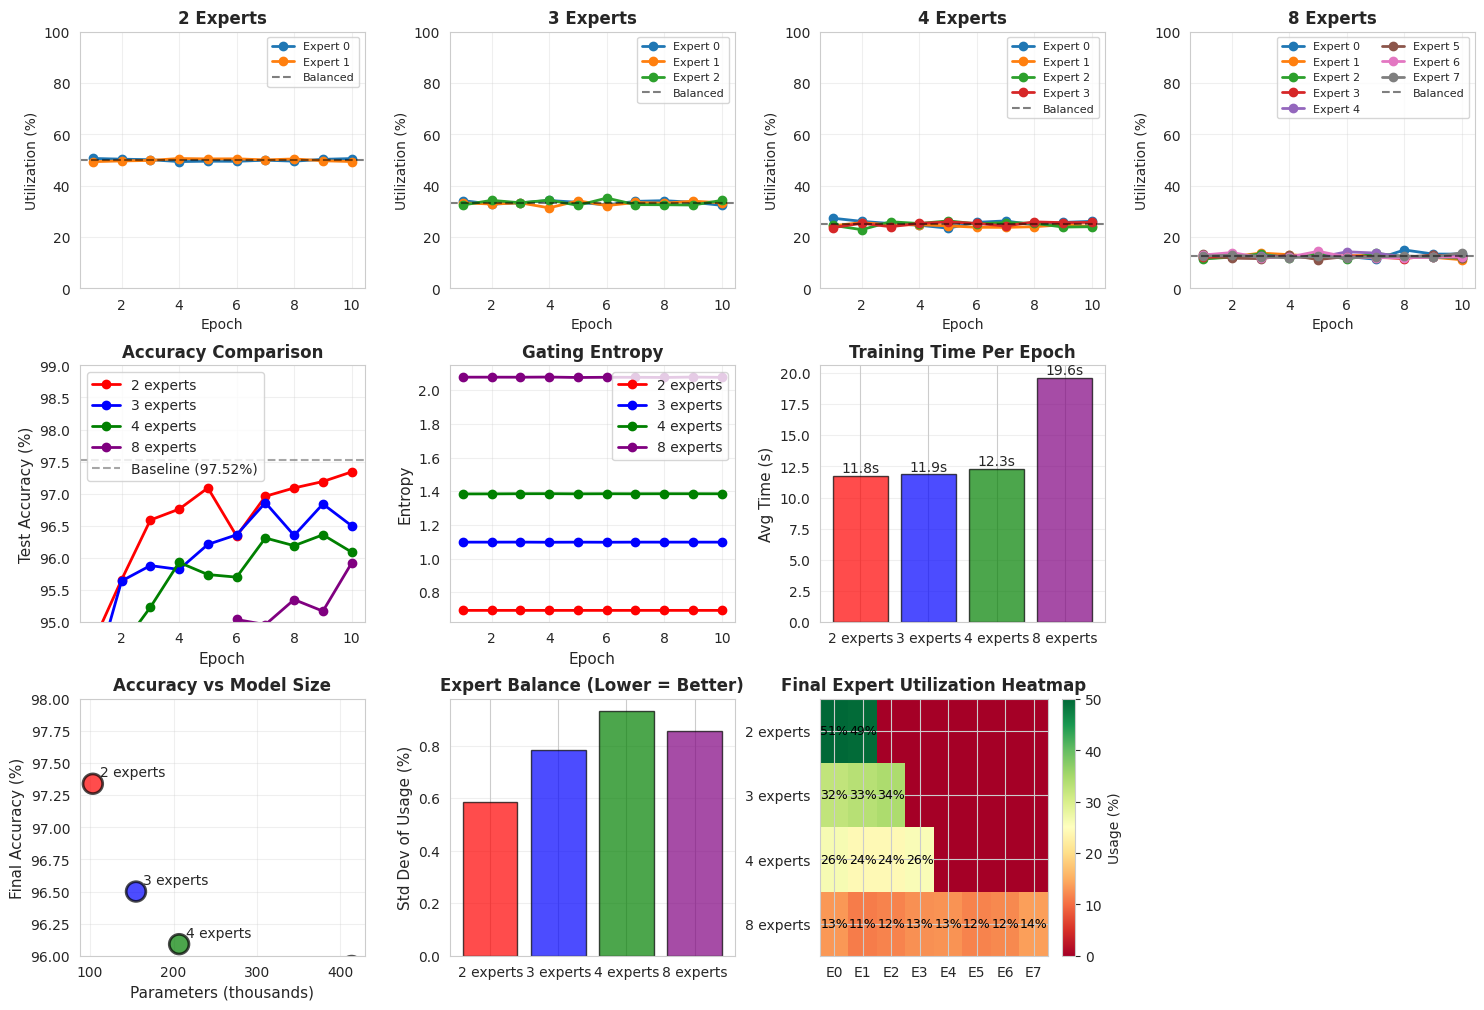


EXPERT COUNT EXPERIMENT - SUMMARY

Experts    Accuracy     Best Acc     Entropy    Std Usage    Params       Time/Epoch  
--------------------------------------------------------------------------------
2          97.34       % 97.34       % 0.693      0.59         103,350      11.8        s
3          96.50       % 96.86       % 1.098      0.78         155,025      11.9        s
4          96.09       % 96.36       % 1.386      0.93         206,700      12.3        s
8          95.92       % 95.92       % 2.077      0.86         413,400      19.6        s

Best Configurations:
   Highest Accuracy: 2 experts (97.34%)
   Best Balance:     2 experts (std=0.59)
   Most Efficient:   2 experts (103,350 params)

Key Findings:
More experts did not improve accuracy
More experts led to less balanced utilization
   Sweet spot appears to be: 2 experts


 Results saved to: /kaggle/working/expert_count_results.pth


In [9]:
# Visualize
plot_expert_count_analysis(results)

# Summary
print_expert_count_summary(results)

# Save results
torch.save(results, '/kaggle/working/expert_count_results.pth')
print(f"\n Results saved to: /kaggle/working/expert_count_results.pth")